In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import warnings
def noop(*args, **kwargs): pass
warnings.warn = noop

In [3]:
from collections import ChainMap
from multiprocessing import cpu_count

In [4]:
from IPython.display import display
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.externals.joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from tsfresh import extract_features, extract_relevant_features
from tqdm import tqdm_notebook as tqdm

In [5]:
from basedir import SAMPLE
from utils import from_feather, to_feather

In [6]:
seed = 1
np.random.seed(seed)

In [7]:
x_trn, y_trn, x_tst = from_feather('x_trn', 'y_trn', 'x_tst')

In [30]:
from tsfresh.feature_extraction.feature_calculators import (
    mean, median, standard_deviation, variance, skewness, kurtosis,
    mean_abs_change, mean_change, mean_second_derivative_central, 
    quantile, autocorrelation, agg_autocorrelation, partial_autocorrelation,
    abs_energy, count_above_mean, count_below_mean, maximum, minimum,
    first_location_of_minimum, first_location_of_maximum, linear_trend,
    sample_entropy, c3, 
    longest_strike_below_mean, longest_strike_above_mean, 
    number_peaks, sum_of_reoccurring_data_points, sum_values,
    large_standard_deviation,
    number_crossing_m, value_count, range_count,
)

In [9]:
def stat(f, **params):
    def wrapper(x):
        return f(x, **params)
    wrapper.__name__ = f.__name__
    return wrapper

In [10]:
def get_series(data, ser_id, *ser_ids):
    ids = [ser_id] + list(ser_ids)
    return data[data.series_id.isin(ids)].copy()

In [11]:
default_stats = (
    mean, median, standard_deviation, variance, skewness, kurtosis, maximum, minimum,
    mean_change, mean_abs_change, count_above_mean, count_below_mean,
    mean_second_derivative_central, sum_of_reoccurring_data_points, 
    abs_energy, sum_values, sample_entropy,
    longest_strike_above_mean, longest_strike_below_mean,
    first_location_of_minimum, first_location_of_maximum,
    *[stat(large_standard_deviation, r=r*0.05) for r in range(1, 20)],
    *[stat(autocorrelation, lag=lag) for lag in range(1, 25)], 
    *[stat(number_peaks, n=n) for n in (1, 2, 3, 5, 7, 10, 25, 50)],
    *[stat(c3, lag=lag) for lag in range(1, 5)],
    *[stat(quantile, q=q) for q in (.1, .2, .3, .4, .5, .6, .7, .8, .9)],
    stat(partial_autocorrelation, param=[{'lag': lag} for lag in range(25)]),
    stat(agg_autocorrelation, param=[{'f_agg': s, 'maxlag': 40} for s in ('mean', 'median', 'var')]),
    stat(linear_trend, param=[
        {'attr': a} for a in ('pvalue', 'rvalue', 'intercept', 'slope', 'stderr')]),
#     stat(number_crossing_m, param=[{'m': m} for m in (-1, 0, 1)]),
)

In [19]:
class StatsFeatures:
    def __init__(self, funcs=default_stats):
        self.funcs = funcs
    
    def __call__(self, data):
        features = {}
        for col in data.columns:
            for func in self.funcs:
                result = func(data[col].values) 
                if hasattr(result, '__len__'):
                    for key, value in result:
                        features[f'{col}__{func.__name__}__{key}'] = value
                else:
                    features[f'{col}__{func.__name__}'] = result
        return features

In [20]:
class SliceFeatures:
    def __init__(self, mode='first', n=5):
        if mode not in {'first', 'middle', 'last'}:
            raise ValueError('unexpected mode')
        self.mode = mode
        self.n = n
    
    def __call__(self, data):
        if self.mode == 'first':
            start, end = 0, self.n
        elif self.mode == 'last':
            start, end = -self.n, len(data)
        elif self.mode == 'middle':
            mid = len(data) // 2
            div, mod = divmod(self.n, 2)
            start, end = mid-div, mid+div+mod
        cols = data.columns
        vec = data.iloc[start:end].values.T.ravel()
        new_cols = [f'{col}_{self.mode}{i}' for i in range(self.n) for col in cols]
        return dict(zip(new_cols, vec))

In [21]:
_, group = next(iter(x_trn.groupby('series_id')))
group = group.drop(columns=['series_id', 'measurement_number'])

In [22]:
features = [
    StatsFeatures(),
    SliceFeatures('first'),
    SliceFeatures('middle'),
    SliceFeatures('last')
]

In [23]:
def generate_features(data, features, ignore=None):
    with Parallel(n_jobs=cpu_count()) as parallel:
        extracted = parallel(delayed(generate_features_for_group)(
            group=group.drop(columns=ignore or []),
            features=features
        ) for _, group in tqdm(data.groupby('series_id')))
    return pd.DataFrame(extracted)

In [24]:
def generate_features_for_group(group, features):
    return dict(ChainMap(*[feat(group) for feat in features]))

In [27]:
# generate_features_for_group(group, features)

In [28]:
ignore = ['series_id', 'measurement_number']

In [29]:
print('Feature extraction on train dataset')
x_trn_rich = generate_features(x_trn, features, ignore=ignore)

Feature extraction on train dataset


In [31]:
print('Feature extraction on train dataset')
x_tst_rich = generate_features(x_tst, features, ignore=ignore)

Feature extraction on train dataset


In [32]:
to_feather(x_trn_rich, 'trn_rich')

PosixPath('/home/ck/data/careercon2019/tmp/trn_rich.feather')

In [33]:
to_feather(x_tst_rich, 'tst_rich')

PosixPath('/home/ck/data/careercon2019/tmp/tst_rich.feather')

In [34]:
x_trn_rich, x_tst_rich, y_trn = from_feather('trn_rich', 'tst_rich', 'y_trn')

In [35]:
enc = LabelEncoder()
y = enc.fit_transform(y_trn['surface'])

In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(x_trn_rich, y, test_size=0.1)

In [37]:
def accuracy(y_true, y_pred):
    n = len(y_true)
    y_hat = y_pred.reshape(9, n).argmax(axis=0)
    value = (y_true == y_hat).mean()
    return 'accuracy', value, True

In [38]:
model = lgb.LGBMClassifier(
    n_estimators=3000, learning_rate=0.005,
    colsample_bytree=0.4, objective='multiclass',
    num_leaves=500, num_class=9)

In [39]:
model.fit(
    X_train, y_train, 
    eval_set=[(X_valid, y_valid)], 
    eval_metric=accuracy,
    early_stopping_rounds=300,
    verbose=150)

Training until validation scores don't improve for 300 rounds.
[150]	valid_0's multi_logloss: 1.21635	valid_0's accuracy: 0.845144
[300]	valid_0's multi_logloss: 0.857744	valid_0's accuracy: 0.84252
[450]	valid_0's multi_logloss: 0.66951	valid_0's accuracy: 0.850394
[600]	valid_0's multi_logloss: 0.560584	valid_0's accuracy: 0.858268
[750]	valid_0's multi_logloss: 0.493501	valid_0's accuracy: 0.860892
[900]	valid_0's multi_logloss: 0.453121	valid_0's accuracy: 0.866142
[1050]	valid_0's multi_logloss: 0.426387	valid_0's accuracy: 0.871391
[1200]	valid_0's multi_logloss: 0.410112	valid_0's accuracy: 0.874016
[1350]	valid_0's multi_logloss: 0.400196	valid_0's accuracy: 0.871391
Early stopping, best iteration is:
[1119]	valid_0's multi_logloss: 0.417769	valid_0's accuracy: 0.874016


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.4,
        importance_type='split', learning_rate=0.005, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=3000, n_jobs=-1, num_class=9, num_leaves=500,
        objective='multiclass', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [21]:
imp = model.feature_importances_
idx = np.argsort(imp)[:100]

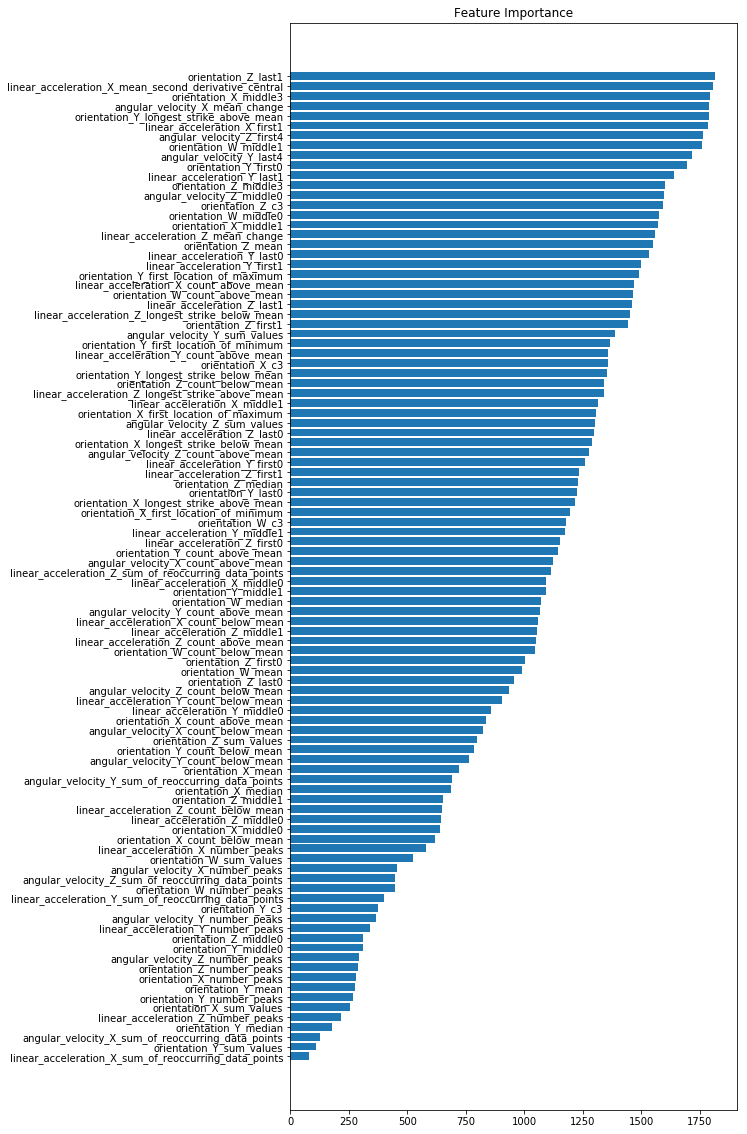

In [25]:
f, ax = plt.subplots(1, 1, figsize=(8, 20))
ax.barh(X_train.columns[idx], imp[idx])
ax.set_title('Feature Importance');

In [41]:
submit = pd.read_csv(SAMPLE)
submit['surface'] = enc.inverse_transform(model.predict(x_tst_rich))
submit.to_csv('submit.csv', index=None)
!kaggle c submit career-con-2019 -f 'submit.csv' -m "LightGBM tsfresh with more features"

100%|██████████████████████████████████████| 52.5k/52.5k [00:00<00:00, 46.6kB/s]
Successfully submitted to CareerCon 2019 - Help Navigate Robots 